In [1]:
import pdb

%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils/")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             precision_score, 
                             recall_score, 
                             accuracy_score, 
                             f1_score, 
                             roc_curve,
                             auc)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from log_reg_utils import *
from time_series_utils import *

%aimport log_reg_utils 
%aimport time_series_utils

import warnings
warnings.filterwarnings("ignore")

In [2]:
genres_df = pd.read_csv("../data/interum/top_genres.csv")
genres_df = genres_df[genres_df.Super_genre != "general"]
genres_df.drop(['Mode', "Key"], axis=1, inplace=True)

In [3]:
genres_df.head()

,Name,Danceability,Energy,Loudness,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,...,URL_features,Duration_ms,time_signature,Genre,Expanded_genre,artist_names,artist_ids,release_date,release_date_precision,Super_genre
0,YuveYuveYu,0.624,0.857,-6.250,0.0542,0.020800,0.206000,0.110,0.324,131.926,...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal,celtic metal,The HU,0b2B3PwcYzQAhuJacmcYgc,2018-10-14,day,metal
1,Gloryhammer,0.517,0.916,-4.933,0.0559,0.000182,0.001910,0.306,0.444,135.996,...,https://api.spotify.com/v1/audio-analysis/4HA3...,300320.0,4.0,celticmetal,celtic metal,Gloryhammer,7dkEByOe0oHqc54qU4hwzV,2019-04-12,day,metal
2,Nostos,0.251,0.894,-4.103,0.0570,0.014400,0.000000,0.123,0.297,114.223,...,https://api.spotify.com/v1/audio-analysis/3W6X...,175353.0,4.0,celticmetal,celtic metal,"Orion's Reign,Minniva","3hRL14TJtJqr7i1IH3D1pU,50KIyycosYOGrBHfLaI1Ju",2018-10-05,day,metal
3,Yggdrasil,0.469,0.743,-5.570,0.0272,0.002220,0.000111,0.276,0.481,86.953,...,https://api.spotify.com/v1/audio-analysis/2gGv...,272292.0,4.0,celticmetal,celtic metal,Brothers of Metal,0WPCPYm5IDNtQjuJOGNPcy,2018-11-09,day,metal
4,Incense&Iron,0.487,0.952,-4.429,0.0613,0.000228,0.000000,0.161,0.329,125.993,...,https://api.spotify.com/v1/audio-analysis/1lRF...,237933.0,4.0,celticmetal,celtic metal,Powerwolf,5HFkc3t0HYETL4JeEbDB1v,2018-07-13,day,metal


In [4]:
super_genres = list(genres_df.Super_genre.unique())

In [5]:
def plot_genre_comparison(df, genre1, genre2, feature):
    subset = df[(df.Super_genre == genre1) | (df.Super_genre == genre2)]
    sns.scatterplot(x=feature, y="Super_genre", data=subset)
    plt.xlabel(feature)
    plt.ylabel("Genre")
    plt.title(f"{genre1} vs {genre2} - {feature}")
    plt.show()
    
    
# plot_genre_comparison(genres_df, "pop", "metal", "Energy")

In [6]:
def compare_genres(df, feature):
    for i in range(len(super_genres)):
        for j in range(i + 1, len(super_genres)):
            genre1 = super_genres[i]
            genre2 = super_genres[j]
            plot_genre_comparison(genres_df, genre1, genre2, feature)

In [7]:
# compare_genres(genres_df, "Tempo")

## Logistic Regression (pairwise)

In [8]:
genres_df.columns

Index(['Name', 'Danceability', 'Energy', 'Loudness', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Type', 'ID', 'Uri', 'Ref_Track', 'URL_features', 'Duration_ms',
       'time_signature', 'Genre', 'Expanded_genre', 'artist_names',
       'artist_ids', 'release_date', 'release_date_precision', 'Super_genre'],
      dtype='object')

In [9]:
def run_log_reg(df, genre1, genre2):
    
    subset = df[(df.Super_genre == genre1) | (df.Super_genre == genre2)]
    
    X = subset[['Danceability', 'Energy', 'Loudness', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',]]
    
    y = subset.Super_genre
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    logreg = LogisticRegression(fit_intercept=False)
    result = logreg.fit(X_train, y_train)
#     predictions = result.predict(X_test)
    
#     precision = precision_score(y, predictions, average=None)
#     recall = recall_score(y, predictions, average=None)
#     accuracy = accuracy_score(y, predictions)
#     f1 = f1_score(y, predictions, average=None)
#     print("PRECISION:\t", precision)
#     print("RECALL:\t\t", recall)
#     print("ACCURACY:\t", accuracy)
#     print("F1:\t\t", f1)

    target_scores = logreg.decision_function(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, target_scores, pos_label=genre1) 
    
    AUC = auc(fpr, tpr)
    
#     sns.lineplot(fpr, tpr)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show()
    
    return AUC, fpr, tpr


def generate_log_reg_table(df, genre_list):
    results = []
    for i in range(len(genre_list) - 1):
        for j in range(i + 1, len(genre_list)):
            genre1 = genre_list[i]
            genre2 = genre_list[j]
            
            AUC, fpr, tpr = run_log_reg(df, genre1, genre2)
            results.append((genre1, genre2, AUC, fpr, tpr))
    
    return pd.DataFrame(results, columns=["genre_1", "genre_2", "AUC", "fpr", "tpr"])

In [10]:
# run_log_reg(genres_df, "pop", "metal")
genre_aucs = generate_log_reg_table(genres_df, super_genres)


In [11]:
genre_aucs.sort_values("AUC", ascending=False)

,genre_1,genre_2,AUC,fpr,tpr
265,techno,r&b,0.995178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.005434782608695652...","[0.0, 0.0022123893805309734, 0.225663716814159..."
260,techno,reggae,0.994808,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.003344481605351170...","[0.0, 0.002183406113537118, 0.5938864628820961..."
206,house,classical,0.992302,"[0.0, 0.0, 0.0, 0.003048780487804878, 0.003048...","[0.0, 0.0013123359580052493, 0.544619422572178..."
264,techno,classical,0.992259,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.002976190476190476...","[0.0, 0.0022675736961451248, 0.244897959183673..."
66,hiphop,classical,0.992081,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0007142857142857143, 0.278571428571428..."
237,country,classical,0.991596,"[0.0, 0.0, 0.0, 0.0030211480362537764, 0.00302...","[0.0, 0.0035211267605633804, 0.485915492957746..."
276,reggae,classical,0.991438,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.003164556962025316...","[0.0, 0.003067484662576687, 0.0214723926380368..."
166,worship,techno,0.988627,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00219780...","[0.0, 0.0030120481927710845, 0.072289156626506..."
267,techno,grunge,0.988284,"[0.0, 0.0, 0.0, 0.03333333333333333, 0.0333333...","[0.0, 0.0022675736961451248, 0.866213151927437..."
270,techno,swing,0.985278,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.011235955056179775...","[0.0, 0.002232142857142857, 0.1316964285714285..."


## Multinomial Logistic Regression

scale all data to be in 0-1 range (this is for loudness and duration)

In [12]:
loudness_scaler = MinMaxScaler()
loudness_scaler.fit(np.array(genres_df["Loudness"]).reshape(-1,1))
scaled_loudness = loudness_scaler.transform(np.array(genres_df["Loudness"]).reshape(-1,1))

duration_scaler = MinMaxScaler()
duration_scaler.fit(np.array(genres_df["Duration_ms"]).reshape(-1,1))
scaled_duration = duration_scaler.transform(np.array(genres_df["Duration_ms"]).reshape(-1,1))

In [13]:
genres_df['scaled_loudness'] = scaled_loudness
genres_df['scaled_duration'] = scaled_duration

In [14]:
# scaled_data = pd.DataFrame(scaled_features, columns=("scaled_loudness", "scaled_duration"))

In [15]:
# genres_df["scaled_loudness"] = scaled_data.scaled_loudness
# genres_df["scaled_duration"] = scaled_data.scaled_duration

These are the top 5 most produced genres in the dataset

In [16]:
list(genres_df.Super_genre.value_counts().index)[0:5]

['indie', 'pop', 'metal', 'rock', 'folk']

In [17]:
genres_df.columns

Index(['Name', 'Danceability', 'Energy', 'Loudness', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Type', 'ID', 'Uri', 'Ref_Track', 'URL_features', 'Duration_ms',
       'time_signature', 'Genre', 'Expanded_genre', 'artist_names',
       'artist_ids', 'release_date', 'release_date_precision', 'Super_genre',
       'scaled_loudness', 'scaled_duration'],
      dtype='object')

In [18]:
genres = [
    'indie', 
    'pop', 
    'metal', 
    'rock', 
#     'folk', 
#     'hiphop', 
#     'punk', 
#     'jazz',
#     'house', 
#     'elect', 
#     'blues', 
#     'techno', 
#     'step', 
#     'worship', 
#     'classical',
#     'reggae', 
#     'guitar', 
#     'country', 
#     'soul', 
#     'dance', 
#     'r&b', 
#     'latin', 
#     'edm',
#     'swing', 
#     'disco', 
#     'synth', 
#     'grunge'
]

features = [
    'Danceability', 
    'Energy', 
    'Speechness',
    'Acousticness', 
    'Instrumentalness', 
    'Liveness', 
    'Valence',
    'scaled_loudness',
    'scaled_duration',
]



# for feature in features:
#     result = run_multinomial_log_reg(genres_df, genres=genres, features=[feature], solver="saga")
#     print(feature, ":\t", result)
    
print("\n\nMultinomial Logistic Regression Mean Accuracy")
run_multinomial_log_reg(genres_df, genres=genres, features=features, solver="saga")



Multinomial Logistic Regression Mean Accuracy


0.4515028432168968

## Incorporate time series

by subsetting our samples by time periods (late 20th and early 21st), we want to see if the relative convergence of stylistic similarities will effect our predictive power.  

Our hypothesis is that the later in time we check, the harder it becomes to distinguish certain styles based on the features provided in our dataset. 

In [19]:
genres_ts = genres_df[genres_df.release_date_precision == "day"]

genres_ts.release_date = genres_ts.release_date.apply(convert_to_datetime)
genres_ts.set_index("release_date", inplace=True)

Subset for late 20th century before feature convergence and then early 21st century after 

In [20]:
late_20th = genres_ts["1980":"1999"]
early_21st = genres_ts["2000":"2018"]

In [21]:
print("Late 20th Century\t",run_multinomial_log_reg(late_20th, genres=genres, features=features, ), "(mean accuracy)")
print("Early 21st Century\t", run_multinomial_log_reg(early_21st, genres=genres, features=features, ), "(mean accuracy)")

Late 20th Century	 0.43373493975903615 (mean accuracy)
Early 21st Century	 0.44560715064312184 (mean accuracy)


When applying synthetic resampleing (SMOTE) to our logistic regression model to bring any imbalences in check, we actually see a decrese in predictive power for samples from the late 20th century compared to those of the early 21st century.  

This also demonstrates a problem with the dataset. There are many more examples in the early 21st century, which could be why we are seeing less variance in these features as time goes on. However, the increased number of datapoints does seem to help predict genres in the 21st century even if the features have little differentiation. 

***
## Graphing ROC

In [22]:
for i in (genre_aucs.sort_values("AUC", ascending=False).index):
    comparison = genre_aucs.iloc[i]
    print("\nGenre 1:\t", comparison.genre_1)
    print("Genre 2:\t", comparison.genre_2)
    print("AUC:\t\t", comparison.AUC)


Genre 1:	 techno
Genre 2:	 r&b
AUC:		 0.9951784340130819

Genre 1:	 techno
Genre 2:	 reggae
AUC:		 0.9948080209139636

Genre 1:	 house
Genre 2:	 classical
AUC:		 0.9923020293195057

Genre 1:	 techno
Genre 2:	 classical
AUC:		 0.9922592052694094

Genre 1:	 hiphop
Genre 2:	 classical
AUC:		 0.9920813186813188

Genre 1:	 country
Genre 2:	 classical
AUC:		 0.9915961022935194

Genre 1:	 reggae
Genre 2:	 classical
AUC:		 0.991438223188631

Genre 1:	 worship
Genre 2:	 techno
AUC:		 0.9886270356149873

Genre 1:	 techno
Genre 2:	 grunge
AUC:		 0.9882842025699169

Genre 1:	 techno
Genre 2:	 swing
AUC:		 0.9852778892455858

Genre 1:	 elect
Genre 2:	 classical
AUC:		 0.9833337031038537

Genre 1:	 step
Genre 2:	 classical
AUC:		 0.983314001425437

Genre 1:	 metal
Genre 2:	 classical
AUC:		 0.98031575228934

Genre 1:	 soul
Genre 2:	 classical
AUC:		 0.9800431154084225

Genre 1:	 techno
Genre 2:	 soul
AUC:		 0.9775789060811515

Genre 1:	 punk
Genre 2:	 classical
AUC:		 0.9772967985674353

Genre 1:	 

AUC:		 0.1345819118568544

Genre 1:	 blues
Genre 2:	 r&b
AUC:		 0.13408104426068498

Genre 1:	 country
Genre 2:	 elect
AUC:		 0.1334815226451792

Genre 1:	 house
Genre 2:	 latin
AUC:		 0.1274519872650714

Genre 1:	 metal
Genre 2:	 rock
AUC:		 0.12338794259789358

Genre 1:	 step
Genre 2:	 techno
AUC:		 0.12310887896825395

Genre 1:	 folk
Genre 2:	 synth
AUC:		 0.12200276243093924

Genre 1:	 blues
Genre 2:	 worship
AUC:		 0.12138605442176871

Genre 1:	 punk
Genre 2:	 swing
AUC:		 0.11986597364464072

Genre 1:	 jazz
Genre 2:	 synth
AUC:		 0.11693639784215061

Genre 1:	 country
Genre 2:	 guitar
AUC:		 0.1141978657985169

Genre 1:	 folk
Genre 2:	 reggae
AUC:		 0.11160074866216181

Genre 1:	 metal
Genre 2:	 step
AUC:		 0.11148231599223288

Genre 1:	 elect
Genre 2:	 guitar
AUC:		 0.10991893180734383

Genre 1:	 elect
Genre 2:	 r&b
AUC:		 0.10856180856180858

Genre 1:	 country
Genre 2:	 disco
AUC:		 0.10676392572944296

Genre 1:	 house
Genre 2:	 soul
AUC:		 0.10649346967320014

Genre 1:	 blues


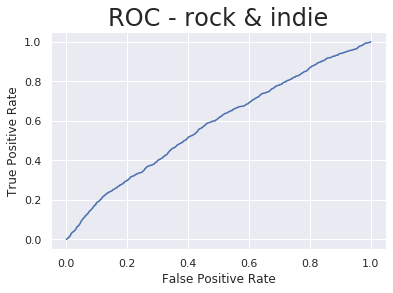

0.5798810160018646

In [23]:
plot_roc(genre_aucs, "rock", "indie")

***


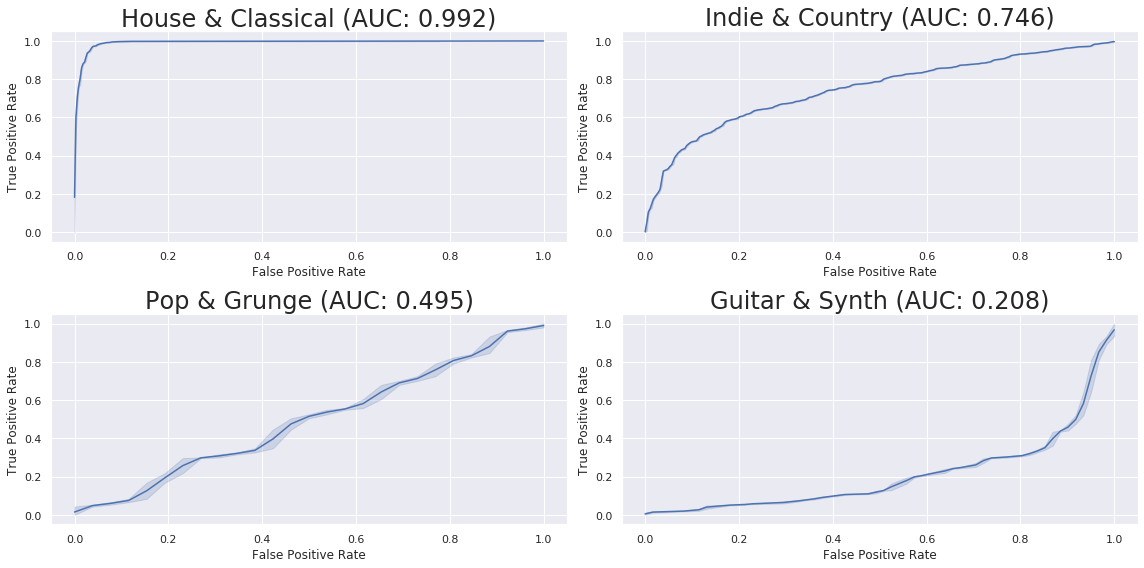

In [42]:
plot_roc_group(genre_aucs, [
    ("house", "classical"),
    ("indie", "country"),
    ("pop", "grunge"),
    ("guitar", "synth")
])